# Modeling infectious disesase spread
I am attempting to learn how to model the spread of infectious diseases using SIR and SEIR models. The tutorials I am using are the articles beginning [here](https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc). A good article about the mathematics of infectious disease spread modeling is [Hethcote 2000](http://www.maths.usyd.edu.au/u/marym/populations/hethcote.pdf).

## Compartmental mdoel - start with three compartments
Fit everyone into one of 3 buckets - **S**usceptible, **I**nfected, **R**ecovered.

First, let's set up some notation:

* Let $N$ be the initial population
* Let $S(t)$ denote the number of susceptible persons at time $t$
* Let $I(t)$ denote the number of infected persons at time $t$
* Let $R(t)$ denote the number of recovered persons at time $t$
* Let $t_{0}$ be a fixed point in time such that $S(t_{0})$ is known in advance
* Let $D$ be the number of days during which an infected person can infect people - there's a word for this but I can't think of what it is
* Let $\beta$ denote the number of people that can be infected by an infected person each day.
* Let $R_{0}$ be the number of people that an infected person can infect. Due to COVID-19 this concept and nomenclature is now well-known to many. We thus have $R_{0}$ = $\beta \times D$.
* Let $\gamma$ be the rate of recovery - the proportion of infected recovering per day. We have $\gamma = \frac{1}{D}$. From this it follows that $R_{0} = \frac{\beta}{\gamma}$.

### The model

We'll follow up with an example. We look at the changes in each of the three compartments over time.

**WARNING!!!** There is a major assumption here - which is that recovered persons do not rejoin the susceptible compartment. If you happen to be thinking of COVID-19 right now - there is [evidence](https://www.the-scientist.com/news-opinion/studies-report-rapid-loss-of-covid-19-antibodies-67650) that this may not be the case.

**Susceptible**: The change in susceptible persons is just saying of the people available to be infected, these people actually were. This is 

$$ \frac{dS}{dt} = -I(t) \times \beta \times \frac{S(t)}{N} $$

In plain language, it's saying that people were moved out of the susceptible compartment and into the infected compartment. The probability of an infected person meeting a susceptible person is $S(t)/N$, and the rate of infection is $\beta$ per day.

**Infected**: The change in infected persons over time is thus

$$ \beta I(t) \frac{S(t)}{N} - \gamma I(t) $$

The first part we already worked out - the second term is the recovered people, which is the people available to recover (the infected) times the rate of recovery.

**Recovered**: The change in recovered people is just

$$ \frac{dR}{dt} = \gamma I(t) $$

*Voila* - we have a set of ordinary differential equations.

### Needed libraries

In [13]:
import numpy as np
from scipy import integrate as si
import matplotlib.pyplot as plt

### A hard example
Let's do the example from the text with made up parameters.

In [20]:
N = 1000 #start with a state of 1000 people
beta = 1.0 #each infected person infects one other person per day
D = 4 #each infection lasts four days
gamma = 1.0 / D
# See here that R0 = beta x D = 4.0. That disease is very virulent

S0, I0, R0 = 999,1,0 # Start with 1 infection, and the rest are susceptible.

In [21]:
# implement the formulae above
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = - beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [22]:
t = np.linspace(0, 50, 50)
y0 = S0, I0, R0
ret = si.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

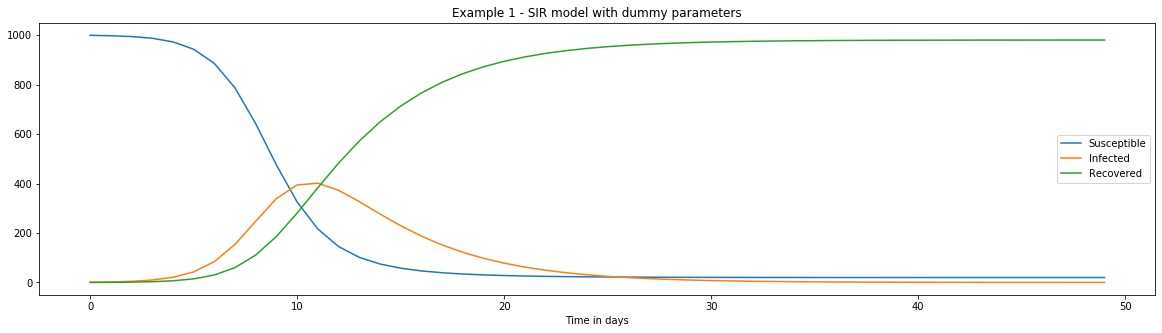

In [23]:
# Plot it
fig = plt.figure(figsize=(20,5))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.legend()
plt.title("Example 1 - SIR model with dummy parameters")
plt.xlabel("Time in days")
plt.show()

Let's change just one initial condition - set $\beta$ to 0.5 - and see what happens.

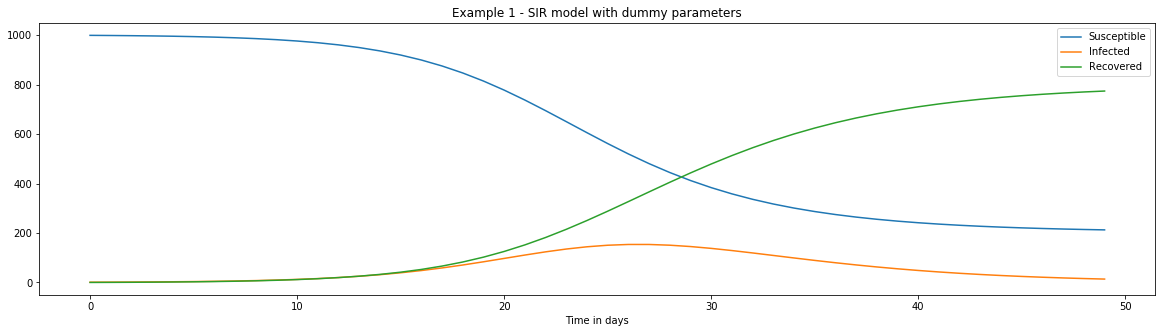

In [24]:
beta = 0.5
ret2 = si.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret2.T
fig = plt.figure(figsize=(20,5))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.legend()
plt.title("Example 1 - SIR model with dummy parameters")
plt.xlabel("Time in days")
plt.show()

That's a big change. Thus it appears that the model is highly dependent on the initial conditions.